## Clustering according to the user's attributes
use KMeans clustering

In [1]:
# import tools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv('../users.csv')
data.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 7 columns):
user_id      38209 non-null int64
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.0+ MB


In [6]:
#id is not useful
data = data.drop(['user_id'], axis = 1)
data = data.drop(['location'], axis = 1)
data.head()

,locale,birthyear,gender,joinedAt,timezone
0,id_ID,1993,male,2012-10-02T06:40:55.524Z,480.0
1,id_ID,1992,male,2012-09-29T18:03:12.111Z,420.0
2,en_US,1975,male,2012-10-06T03:14:07.149Z,-240.0
3,en_US,1991,female,2012-11-04T08:59:43.783Z,210.0
4,id_ID,1995,female,2012-09-10T16:06:53.132Z,420.0


### Feature Engineering

In [7]:
import datetime
import hashlib
import locale

from collections import defaultdict
from sklearn.preprocessing import normalize

class FeatureEng:
    def __init__(self):
         # load locales
        self.localeIdMap = defaultdict(int)
        for i, l in enumerate(locale.locale_alias.keys()):
          self.localeIdMap[l] = i + 1
        
        self.genderIdMap = defaultdict(int, {'NaN': 0, "male":1, "female":2})

  
    def getLocaleId(self, locstr):
        return self.localeIdMap[locstr.lower()]

    def getGenderId(self, genderStr):
        return self.genderIdMap[genderStr]

    def getJoinedYearMonth(self, dateString):
        try:
            dttm = datetime.datetime.strptime(dateString, "%Y-%m-%dT%H:%M:%S.%fZ")
            return (dttm.year-2010)*12 + dttm.month
        except:  #fill none with 0
          return 0

    def getBirthYearInt(self, birthYear):
        #缺失补0
        try:
          return 0 if birthYear == "None" else int(birthYear)
        except:
          return 0

    def getTimezoneInt(self, timezone):
        try:
          return int(timezone)
        except:  
          return 0

In [8]:
FE = FeatureEng()

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'TimezoneInt']
n_cols = len(cols)
userMatrix = np.zeros((data.shape[0],n_cols), dtype=np.int)

for i in range(data.shape[0]): 
    userMatrix[i, 0] = FE.getLocaleId(data.loc[i,'locale'])
    userMatrix[i, 1] = FE.getBirthYearInt(data.loc[i,'birthyear'])
    userMatrix[i, 2] = FE.getGenderId(data.loc[i,'gender'])
    userMatrix[i, 3] = FE.getJoinedYearMonth(data.loc[i,'joinedAt'])
    userMatrix[i, 4] = FE.getTimezoneInt(data.loc[i,'timezone'])

# nomalize data
userMatrix = normalize(userMatrix, norm="l1", axis=0, copy=False)

data_FE = pd.DataFrame(data=userMatrix, columns=cols) 

### Clustering use MiniBatchKMeans

In [9]:
def K_cluster(K, data):
    print("K-means begin with clusters: {}".format(K));
    
    #K-means,fit in the train dataset
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(data)
    
    # evaluate by CH_score
    CH_score = metrics.calinski_harabaz_score(data,mb_kmeans.predict(data))
    data_FE['cluster_'+ str(K)] = mb_kmeans.predict(data_FE)
    print("CH_score: ", CH_score)
    return CH_score

In [10]:
Ks = [20, 40, 80]
CH_scores = []
for K in Ks:
    ch = K_cluster(K, data_FE)
    CH_scores.append(ch)

K-means begin with clusters: 20
CH_score:  43818.2671119
K-means begin with clusters: 40
CH_score:  8.91099611091e+14
K-means begin with clusters: 80
CH_score:  19024116.1033


In [11]:
#check results
data_FE.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt,cluster_20,cluster_40,cluster_80
0,0.000036,0.000027,0.000019,0.000026,0.000036,3,30,1
1,0.000036,0.000027,0.000019,0.000026,0.000031,3,30,1
2,0.000020,0.000027,0.000019,0.000026,-0.000018,6,35,23
3,0.000020,0.000027,0.000038,0.000027,0.000016,18,5,3
4,0.000036,0.000027,0.000038,0.000026,0.000031,4,9,7


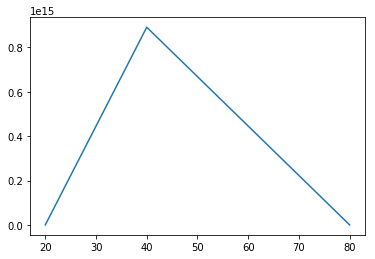

In [12]:
# make plot and find best parameter
plt.plot(Ks, np.array(CH_scores))
data_FE.to_csv('cluster.csv')

It shows that 40 is the best k value